# Primera entrega de proyecto final

# OBJETIVO: Predecir el precio de las viviendas a partir de un historial de ventas en la región de Connecticut
<br> <br/>
## Contexto comercial

El mercado de bienes raíces en Estados Unidos es extremadamente diverso y dinámico. Abarca una amplia variedad de propiedades, desde viviendas unifamiliares hasta edificios comerciales, terrenos vacantes y propiedades de inversión.

Para iniciar una negociación es muy útil contar con un "Precio Tentativo" que dependa de un historial de ventas casa. Asimismo, resultaría muy interesante contar con una estimación automática, dejando de lado el criterio del tasador que quizás podría ser subjetivo.
<br> <br/>
## Problema comercial
Al no contar con el precio estimado de la vivienda, es muy dificil para el intermediario poder establecer un punto de negociación de precio entre comprador y vendedor. Por ello es que se requiere contar con un precio estimado en función a ventas históricas de casas similares para que el proceso de negociación sea más ameno para ambas partes.
<br> <br/>
### Contexto analítico
Para poder desarrollar el modelo se cuenta con un listado de todas las ventas de bienes raíces con un precio de venta de $2,000 o más que ocurren entre el 1 de octubre y el 30 de septiembre de cada año, haciendo un total de 997.213 registros de ventas. Para cada registro de venta, el archivo incluye: ciudad, dirección de la propiedad, fecha de venta, tipo de propiedad (residencial, departamento, comercial, industrial o terreno baldío), precio de venta y tasación de la propiedad.

Los datos se recopilan de acuerdo con los Estatutos Generales de Connecticut

Las ventas anuales de bienes raíces se informan por año de lista general (del 1 de octubre al 30 de septiembre de cada año). Por ejemplo, las ventas del GL 2018 son del 01/10/2018 al 30/09/2019.

Metadatos actualizados: 12 de agosto de 2023
<br> <br/>
Las variables disponibles (14) son las siguientes:
<br> <br/>
1. Serial Number: numero de serie
2. List Year: año de la venta. (recordemos que el año se concidera desde 01/10 al 30/09 de cada año calendario)
3. Date Recorded: fecha de registro
4. Town: ciudad
5. Address: direccion
6. Assessed Value: valor tasado
7. Sale Amount: valor de venta
8. Sales Ratio: ratio de venta ( valor tasado / valor de venta)
9. Property Type: tipo de propiedad
10. Residential Type: tipo residencial
11. Non Use Code: codigo de no uso
12. Assessor Remarks: Observaciones del asesor
13. OPM remarks: Comentario de la operación
14. Location: ubicación

In [1]:
# Importamos paqueteria necesaria.

import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from datetime import datetime


In [2]:
# Montamos el Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Definimos el directorio de trabajo a la ruta deseada
path = '/content/drive/MyDrive/Colab Notebooks/Entregas/12 - Segunda pre-entrega de trabajo final/Real_Estate_Sales_2001-2020_GL.csv'

# Levantamos el archivo
df = pd.read_csv(path)
print(df.head())
print(df.shape)

<ipython-input-3-2653009fa118>:5: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


   Serial Number  List Year Date Recorded     Town                Address  \
0        2020348       2020    09/13/2021  Ansonia        230 WAKELEE AVE   
1          20002       2020    10/02/2020  Ashford        390 TURNPIKE RD   
2         200212       2020    03/09/2021     Avon       5 CHESTNUT DRIVE   
3         200243       2020    04/13/2021     Avon  111 NORTHINGTON DRIVE   
4         200377       2020    07/02/2021     Avon     70 FAR HILLS DRIVE   

   Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
0        150500.0     325000.0       0.4630    Commercial              NaN   
1        253000.0     430000.0       0.5883   Residential    Single Family   
2        130400.0     179900.0       0.7248   Residential            Condo   
3        619290.0     890000.0       0.6958   Residential    Single Family   
4        862330.0    1447500.0       0.5957   Residential    Single Family   

  Non Use Code Assessor Remarks OPM remarks Location  
0          Na

# Variable Target: Sale Amount

La variable objetivo es el precio de venta de la propiedad.

Esta variable es de tipo **numérica**
<br> <br/>
A continuación se presentarán algunas estadísticas para entender el comportamiento, formato y distribución de esta variable.

In [4]:
# Algunas estadísticas
variable_target = df['Sale Amount']
pd.options.display.float_format = '{:.1f}'.format # quitamos el formato de notación cientifica.
variable_target.describe().round(0)

count       997213.0
mean        391151.0
std        5347270.0
min              0.0
25%         140000.0
50%         225000.0
75%         365000.0
max     5000000000.0
Name: Sale Amount, dtype: float64

In [5]:
# Analizamos df en busca de valores menores a los 2.000
df_filtrado = df[df['Sale Amount'] < 2000]
df_filtrado

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
86,10045,2001,01/03/2002,Bethany,9 SIMPSON CT,96590.0,0.0,0.0,NaN,NaN,1,NaN,NaN,NaN
139,10041,2001,10/04/2001,Stratford,86 MINOR CROSS,107090.0,0.0,0.0,NaN,NaN,1,NaN,NaN,NaN
150,10482,2001,01/10/2002,Stratford,129 BAYBERRY LN,140390.0,0.0,0.0,NaN,NaN,1,NaN,NaN,NaN
159,10466,2001,01/07/2002,Stratford,1086 ESSEX PL,150640.0,0.0,0.0,NaN,NaN,1,NaN,NaN,NaN
185,10124,2001,10/23/2001,Stratford,1093 BARNUM AVE,200980.0,0.0,0.0,NaN,NaN,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902489,180046,2018,10/29/2018,Berlin,63 STONY MILL LANE,137600.0,0.0,0.0,Condo,Condo,29 - No Consideration,non-qualified sale - life use,NaN,NaN
914892,180006,2018,10/05/2018,Winchester,53 CENTER ST,79100.0,0.0,0.0,Two Family,Two Family,18 - In Lieu Of Foreclosure,IN LEIU OF FORECLOSURE,NaN,NaN
921479,180032,2018,10/31/2018,Winchester,131 BELVIDERE,75950.0,0.0,0.0,Single Family,Single Family,14 - Foreclosure,SALE OF FORECLOSURE,NaN,NaN
924767,180005,2018,10/03/2018,Woodstock,ENGLISH NEIGHBORHOOD RD,5900.0,1200.0,4.9,NaN,NaN,28 - Use Assessment,NaN,NaN,NaN


---
Detectamos 2.139 registros cuyo precio de venta es menor a los 2.000 dolares.
Consideraremos como información incorrecta todos las ventas con precio de venta menor a 2.000 dolares, debido a que el enunciado nos dice que este conjunto de datos pertenece a todas las ventas mayores o iguales a 2.000 realizadas en un periodo del tiempo.
Procederemos a eliminarlos de nuestra base de datos.

---

In [6]:
# Eliminamos registros de la columan Sale Amount menores a 2.000
df = df[df['Sale Amount'] > 2000]

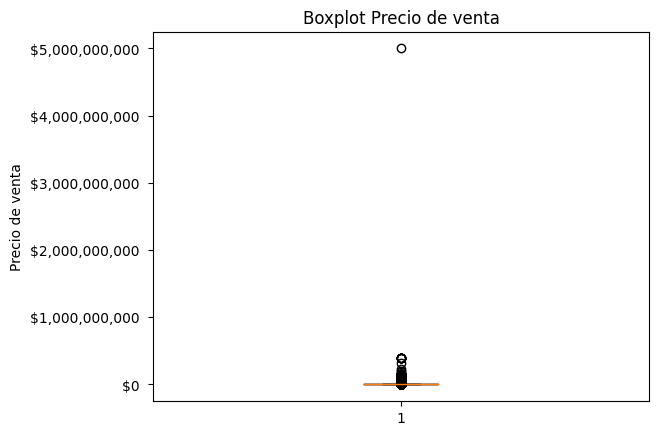

In [7]:
#Analizamos la variable target en busca de outliers que puedan entorpecer nuestro modelo.
# Boxplot
fig, ax = plt.subplots()
ax.boxplot(df['Sale Amount'])
ax.set_title('Boxplot Precio de venta')
ax.set_xlabel('')
ax.set_ylabel('Precio de venta')
ax.yaxis.set_major_formatter('${:,.0f} '.format)

In [8]:
# Analizamos df en busca de valores mayores a 500.000.000
df_filtrado1 = df[df['Sale Amount'] > 500000000]
df_filtrado1

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
59835,20200091,2020,08/19/2021,Willington,456 TOLLAND TPKE,2238530.0,5000000000.0,0.0,Apartments,NaN,25 - Other,APARTMENTS-COMMERICAL,INCORRECT SALE PRICE,NaN


In [9]:
# Eliminamos registros de la columan Sale Amount mayores a 500.000.000
df = df[df['Sale Amount'] < 500000000]

Text(0.5, 1.0, 'Distribución de Sale Amount')

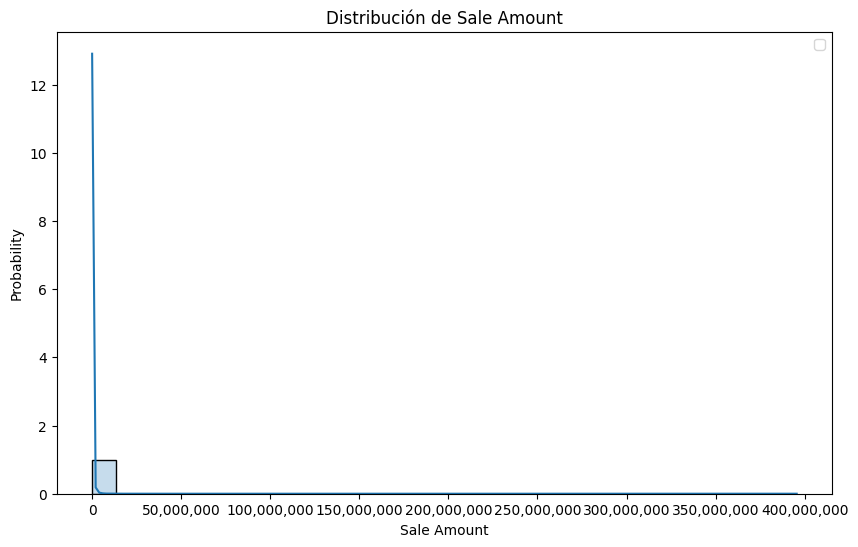

In [10]:
# Histograma variable target
plt.figure(figsize=(10, 6))
# Histograma
ax = sns.histplot(data = df,
             x = 'Sale Amount',
             bins = 30,
             alpha = 0.25,
             kde = True,
             stat='probability')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.legend()
plt.title('Distribución de Sale Amount')

---
Seguimos detectanto valores atipicos y mucha concentracion de datos en un rango de precios particular, por lo que procederemos a calcular el rango intercuartílico con el que continuaremos analizando.

---

In [11]:
# Calculamos el rango intercuartílico (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

<ipython-input-11-fd383f717a8a>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
<ipython-input-11-fd383f717a8a>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)


In [12]:
# Definimos un umbral para identificar valores atípicos (por ejemplo, 1.5 veces el IQR)
umbral = 1.5

In [13]:
# Encontramos los índices de filas con valores atípicos en al menos una columna
indices_valores_atipicos = ((df < (Q1 - umbral * IQR)) | (df > (Q3 + umbral * IQR))).any(axis=1)

<ipython-input-13-7a98b6ffd14d>:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  indices_valores_atipicos = ((df < (Q1 - umbral * IQR)) | (df > (Q3 + umbral * IQR))).any(axis=1)


In [14]:
# Filtramos las filas sin valores atípicos
df = df[~indices_valores_atipicos]

In [15]:
# Analizamos estadisticamente nuevamente la variable.
variable_target1 = df['Sale Amount']
pd.options.display.float_format = '{:.1f}'.format # quitamos el formato de notación cientifica.
variable_target1.describe().round(0)

count   765750.0
mean    246026.0
std     135318.0
min       2030.0
25%     150000.0
50%     220000.0
75%     320000.0
max     702500.0
Name: Sale Amount, dtype: float64

Text(0.5, 1.0, 'Distribución de Sale Amount')

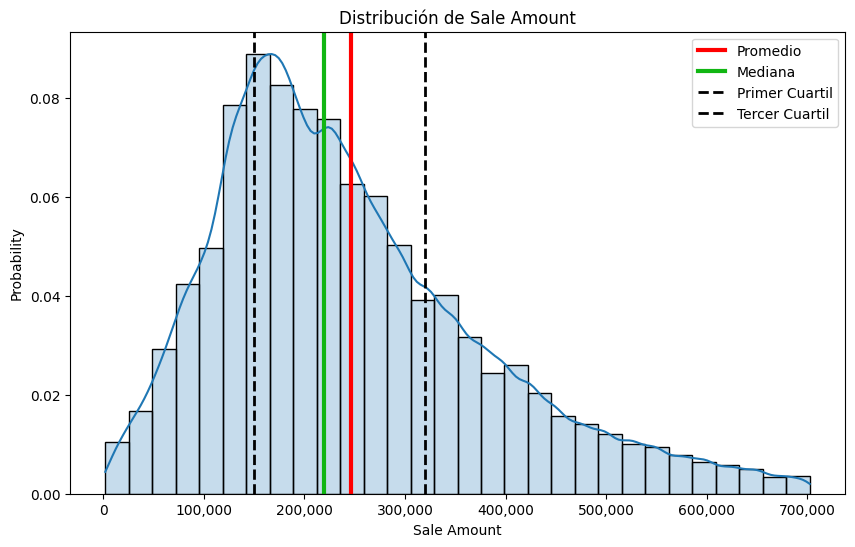

In [16]:
# Histograma variable target
# Primero calculamos algunas medidas que quiero presentar
media = variable_target1.mean()
mediana = variable_target1.median()
primer_cuartil = variable_target1.quantile(0.25)
tercer_cuartil = variable_target1.quantile(0.75)

# Luego graficamos
plt.figure(figsize=(10, 6))
# Histograma
ax = sns.histplot(data = df,
             x = 'Sale Amount',
             bins = 30,
             alpha = 0.25,
             kde = True,
             stat='probability')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
# Agregamos linea de promedio
plt.axvline(x = media,
            color = 'red',
            linestyle = '-',
            label = 'Promedio',
            linewidth = 3)
# Agregamos linea de mediana
plt.axvline(x = mediana,
            color = '#11B613',
            linestyle = '-',
            label = 'Mediana',
            linewidth = 3)
# Agregamos linea de primer cuartil
plt.axvline(x = primer_cuartil,
            color = 'black',
            linestyle = '--',
            label = 'Primer Cuartil',
            linewidth = 2)
# Agregamos linea de tercer cuartil
plt.axvline(x = tercer_cuartil,
            color = 'black',
            linestyle = '--',
            label = 'Tercer Cuartil',
            linewidth = 2)

plt.legend()

plt.title('Distribución de Sale Amount')

Análisis Variable Target: Sale Amount

Como podemos observar la mediana es menor que el promedio, significa que la distribución es asimétrica hacia la derecha (positiva). Esto indica que la mayoría de los valores se encuentran en la parte inferior de la distribución, lo que hace que el tercer cuartil esté más cerca de la cola derecha de la distribución.

Al tratar con una variable target de este tipo de distribución, una buena prácica suele ser intentar predecir el logaritmo de la variable, para suavizar un poco la curva de valores posibles.
<br> <br/>
A continuación se presentará el histograma del logaritmo de la variable target.

Text(0.5, 1.0, 'Distribución de Sale Amount transformado a Logaritmo')

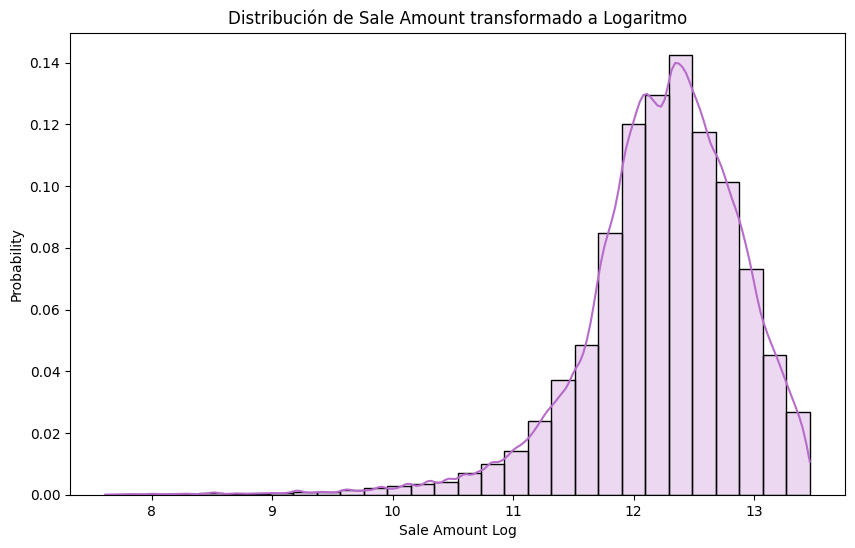

In [17]:
# Primero generamos la variable logaritmica
df['Sale Amount Log'] = np.log(df['Sale Amount'])

# Luego graficamos
plt.figure(figsize=(10, 6))
# Histograma
sns.histplot(data = df,
             x = 'Sale Amount Log',
             bins = 30,
             alpha = 0.25,
             kde = True,
             stat='probability',
             color = '#B76BCB')
plt.title('Distribución de Sale Amount transformado a Logaritmo')

---
## Conclusión:

Al calcular el logaritmo de la variable y graficarlo, podemos observar que la distribucion de los valores cambió, generando ahora una pendiente negativa pero con mayor sesgo que la variable original.

Por lo que utilizaremos la variable original para continuar con el análisis, no la variable logaritmica que calculamos.

---

# Exploración de valores vacíos
A continuación se evaluará la precencia de valores vacíos en las variables disponibles.

In [18]:
df.isnull().sum()

Serial Number            0
List Year                0
Date Recorded            0
Town                     0
Address                 12
Assessed Value           0
Sale Amount              0
Sales Ratio              0
Property Type       309122
Residential Type    312115
Non Use Code        601332
Assessor Remarks    676209
OPM remarks         758700
Location            614331
Sale Amount Log          0
dtype: int64

Podemos observar que las columnas con nulos, son:

1. Address: direccion (12 nulos)
2. Property Type: tipo de propiedad (309.122 nulos)
3. Residential Type: tipo residencial (312.115 nulos)
4. Non Use Code: codigo de no uso (601.332 nulos)
5. Assessor Remarks: Observaciones del asesor (676.209 nulos)
6. OPM remarks: Comentario de la operación (758.700 nulos)
7. Location: ubicación (614.331 nulos)

Luego de analizar las columnas, podemos decir que la falta de informacion en estas columnas es porque no se capturó. Solo reemplazaremos estos nulos con 'No data' para luego pordes transformar estas variables categoricas, en numericas y poderlas utilizar para buscar correlacion con la variable target.



In [19]:
# Tratamiento de nulos
# Rellenamos 'Address', 'Property Type', 'Residential Type', 'Non Use Code', 'Assessor Remarks', 'OPM remarks', 'Location' con 'No data'
Sin_Datos = 'No data'
df['Address'].fillna(Sin_Datos, inplace=True)
df['Property Type'].fillna(Sin_Datos, inplace=True)
df['Residential Type'].fillna(Sin_Datos, inplace=True)
df['Non Use Code'].fillna(Sin_Datos, inplace=True)
df['Assessor Remarks'].fillna(Sin_Datos, inplace=True)
df['OPM remarks'].fillna(Sin_Datos, inplace=True)
df['Location'].fillna(Sin_Datos, inplace=True)

In [20]:
# Verificamos la existencia de nulos en DataFrame
df.isnull().sum()

Serial Number       0
List Year           0
Date Recorded       0
Town                0
Address             0
Assessed Value      0
Sale Amount         0
Sales Ratio         0
Property Type       0
Residential Type    0
Non Use Code        0
Assessor Remarks    0
OPM remarks         0
Location            0
Sale Amount Log     0
dtype: int64

In [21]:
df.head(2)

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,Sale Amount Log
1,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.6,Residential,Single Family,No data,No data,No data,No data,13.0
2,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7,Residential,Condo,No data,No data,No data,No data,12.1


# TRAIN Y TEST

In [22]:
cantidad_registros = df.shape[0]
semilla = 22
np.random.seed(semilla)
serie_random = np.random.rand(cantidad_registros)
df['TRAIN'] = np.where(serie_random < 0.3, 0, 1)

In [23]:
# Cómo quedó la división??
resumen = df.groupby('TRAIN').agg(
    Cant = ('Sale Amount', 'count'),
    Media_Precio_Venta = ('Sale Amount', 'mean')
).reset_index()
resumen

,TRAIN,Cant,Media_Precio_Venta
0,0,229874,246196.7
1,1,535876,245952.2


In [24]:
# validamos informacion con mas pasos
#Filtra el DataFrame = 1 y calculamos Media
filtro = df.loc[df['TRAIN'] == 1]

# Calcula la media de la columna filtrada
media = filtro['Sale Amount'].mean()
media

245952.24600594162

In [25]:
# Filtra el DataFrame = 0 y calculamos Media
filtro1 = df.loc[df['TRAIN'] == 0]

# Calcula la media de la columna filtrada
media1 = filtro1['Sale Amount'].mean()
media1

246196.67226036877

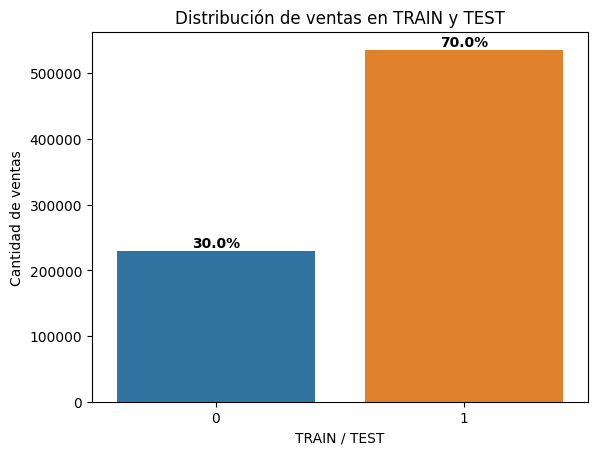

In [26]:
cantidad = len(df['Sale Amount'])

sns.countplot(data = df,
              x = "TRAIN")
plt.xlabel('TRAIN / TEST')
plt.ylabel('Cantidad de ventas')
plt.title('Distribución de ventas en TRAIN y TEST')
ax = plt.gca()
for p in ax.patches:
    x_text = p.get_x() + p.get_width() / 2.0  # Calcula la posición x del texto
    y_text = p.get_height()  # Toma la altura de la columna
    ax.text(x_text, y_text, f'{str(round(int(y_text)/cantidad,2) * 100)}%', # Indica posición x e y, y texto a mostrar
            ha = 'center', # Alineación horizontal
            va = 'bottom',  # Alineación vertical
            fontsize = 10, color = 'black', fontweight = 'bold')
plt.show()

Text(0.5, 1.0, '¿Es el promedio de las ventas igual en ambas subporciones de la muestra?')

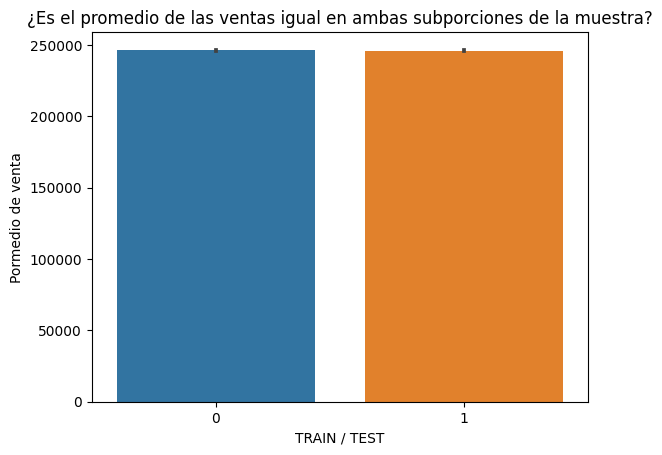

In [27]:
sns.barplot(data = df,
                x = 'TRAIN',
                y = 'Sale Amount')
plt.xlabel('TRAIN / TEST')
plt.ylabel('Pormedio de venta')
plt.title('¿Es el promedio de las ventas igual en ambas subporciones de la muestra?')

In [28]:
df.shape

(765750, 16)

In [29]:
#Generamos nuestro DF_TEST
DF_TEST = df.loc[df['TRAIN'] == 0]
DF_TEST

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,Sale Amount Log,TRAIN
1,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.6,Residential,Single Family,No data,No data,No data,No data,13.0,0
14,201295,2020,09/09/2021,Bristol,609 CAMP ST,144340.0,249900.0,0.6,Residential,Single Family,No data,No data,No data,No data,12.4,0
16,200354,2020,12/29/2020,Bristol,391 TIFFANY LA,173740.0,299000.0,0.6,Residential,Single Family,No data,No data,No data,No data,12.6,0
18,201212,2020,08/23/2021,Bristol,8 JENNINGS TERR,88060.0,91000.0,1.0,Residential,Single Family,14 - Foreclosure,FORECLOSURE SALE OUT OF BANK,No data,No data,11.4,0
22,200117,2020,04/12/2021,Canton,52 COUNTRY LANE,160850.0,280000.0,0.6,Residential,Single Family,No data,No data,No data,No data,12.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997203,190302,2019,11/29/2019,Waterbury,122 WOLCOTT ST,77870.0,112000.0,0.7,Three Family,Three Family,No data,No data,No data,No data,11.6,0
997205,190161,2019,03/02/2020,Newington,22 ROCKLEDGE DR,306000.0,456000.0,0.7,Single Family,Single Family,No data,No data,No data,No data,13.0,0
997206,19921,2019,11/18/2019,West Haven,75 CLOVER ST,125230.0,246000.0,0.5,Single Family,Single Family,No data,No data,No data,POINT (-72.96445 41.25722),12.4,0
997208,190272,2019,06/24/2020,New London,4 BISHOP CT,60410.0,53100.0,1.1,Single Family,Single Family,14 - Foreclosure,No data,No data,No data,10.9,0


In [30]:
#Generamos nuestro nuestro DF_TRAIN será nuestro df en el resto de los analisis
DF_TRAIN = df.loc[df['TRAIN'] == 1]
df = DF_TRAIN
df

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,Sale Amount Log,TRAIN
2,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7,Residential,Condo,No data,No data,No data,No data,12.1,1
9,20139,2020,12/16/2020,Bethel,16 DEEPWOOD DRIVE,171360.0,335000.0,0.5,Residential,Single Family,No data,No data,No data,No data,12.7,1
10,200086,2020,08/10/2021,Bethlehem,39 WOODLAND RD,168900.0,352000.0,0.5,Residential,Single Family,No data,No data,No data,POINT (-73.18197 41.64672),12.8,1
15,200032,2020,10/08/2020,Bristol,9 LESLIE COURT,94920.0,155000.0,0.6,Residential,Single Family,No data,No data,No data,No data,12.0,1
17,200527,2020,03/01/2021,Bristol,25 WARD ST,85680.0,183000.0,0.5,Residential,Two Family,No data,No data,No data,No data,12.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997198,190365,2019,02/10/2020,West Hartford,191 HUNTER DRIVE,315420.0,380000.0,0.8,Single Family,Single Family,No data,No data,No data,No data,12.8,1
997199,190159,2019,12/13/2019,Wallingford,530-A5 CENTER ST,128700.0,175000.0,0.7,Condo,Condo,No data,No data,No data,No data,12.1,1
997201,191401,2019,07/30/2020,Waterbury,355 PIERPONT RD,81070.0,142000.0,0.6,Single Family,Single Family,No data,No data,No data,No data,11.9,1
997209,190284,2019,11/27/2019,Waterbury,126 PERKINS AVE,68280.0,76000.0,0.9,Single Family,Single Family,25 - Other,PRIVATE SALE,No data,No data,11.2,1


# MODELO DE ENTRENAMIENTO Y RESULTADOS

### Correlación
Lo próximo que analizaremos es la correlación entre cada variable disponible, y la variable target.
 <br> <br/>
 Debido a que no contamos con muchas variables numericas en el DF, generaremos nuevas variables numericas a partir de las variables categoricasa, para poder analizar la relacion con la variable target.
 Luego procederemos a relaizar un analisis mas en profundidad de alguna de ellas.

In [31]:
# Generamos nueva variable por medio de la funcion MEAN para poder utilizar dicha variable en el modelo.
Agrupacion_Town = df.groupby('Town')['Sale Amount'].mean().reset_index()
# Renombramos la columna "Sale Amount" por un nombre facil de detectar.
Agrupacion_Town.rename(columns={'Sale Amount': 'Town_mean'}, inplace=True)
Agrupacion_Town

,Town,Town_mean
0,***Unknown***,282450.0
1,Andover,236668.8
2,Ansonia,205529.9
3,Ashford,184392.8
4,Avon,333536.8
...,...,...
165,Windsor Locks,182392.2
166,Wolcott,232948.1
167,Woodbridge,369970.4
168,Woodbury,278422.4


In [32]:
# Fusionsmos (df) con el DataFrame (Agrupacion_Town) utilizando la columna "Town" como clave
df = df.merge(Agrupacion_Town, on='Town', how='left')

In [33]:
# Generamos nueva variable por medio de la funcion MEAN para poder utilizar dicha variable en el modelo.
Agrupacion_Property = df.groupby('Property Type')['Sale Amount'].mean().reset_index()
# Renombramos la columna "Sale Amount" por un nombre facil de detectar.
Agrupacion_Property.rename(columns={'Sale Amount': 'Property_mean'}, inplace=True)
Agrupacion_Property

,Property Type,Property_mean
0,Apartments,350821.6
1,Commercial,300313.3
2,Condo,201917.7
3,Four Family,246133.2
4,Industrial,246074.5
5,No data,235171.0
6,Public Utility,47272.0
7,Residential,286655.2
8,Single Family,267865.9
9,Three Family,207048.0


In [34]:
# Fusionsmos (df) con el DataFrame (Agrupacion_Property) utilizando la columna "Property Type" como clave
df = df.merge(Agrupacion_Property, on='Property Type', how='left')

In [35]:
# Generamos nueva variable por medio de la funcion MEAN para poder utilizar dicha variable en el modelo.
Agrupacion_Residential = df.groupby('Residential Type')['Sale Amount'].mean().reset_index()
# Renombramos la columna "Sale Amount" por un nombre facil de detectar.
Agrupacion_Residential.rename(columns={'Sale Amount': 'Residential_mean'}, inplace=True)
Agrupacion_Residential

,Residential Type,Residential_mean
0,Condo,203432.0
1,Four Family,252259.9
2,No data,234862.2
3,Single Family,272056.8
4,Three Family,213964.4
5,Two Family,214570.5


In [36]:
# Fusionsmos (df) con el DataFrame (Agrupacion_Residential) utilizando la columna "Residential Type" como clave
df = df.merge(Agrupacion_Residential, on='Residential Type', how='left')

In [37]:
df.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,Sale Amount Log,TRAIN,Town_mean,Property_mean,Residential_mean
0,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7,Residential,Condo,No data,No data,No data,No data,12.1,1,333536.8,286655.2,203432.0
1,20139,2020,12/16/2020,Bethel,16 DEEPWOOD DRIVE,171360.0,335000.0,0.5,Residential,Single Family,No data,No data,No data,No data,12.7,1,324309.9,286655.2,272056.8
2,200086,2020,08/10/2021,Bethlehem,39 WOODLAND RD,168900.0,352000.0,0.5,Residential,Single Family,No data,No data,No data,POINT (-73.18197 41.64672),12.8,1,272773.3,286655.2,272056.8
3,200032,2020,10/08/2020,Bristol,9 LESLIE COURT,94920.0,155000.0,0.6,Residential,Single Family,No data,No data,No data,No data,12.0,1,184745.5,286655.2,272056.8
4,200527,2020,03/01/2021,Bristol,25 WARD ST,85680.0,183000.0,0.5,Residential,Two Family,No data,No data,No data,No data,12.1,1,184745.5,286655.2,214570.5


In [38]:
# Verificamos la existencia de nulos en DataFrame
df.isnull().sum()

Serial Number       0
List Year           0
Date Recorded       0
Town                0
Address             0
Assessed Value      0
Sale Amount         0
Sales Ratio         0
Property Type       0
Residential Type    0
Non Use Code        0
Assessor Remarks    0
OPM remarks         0
Location            0
Sale Amount Log     0
TRAIN               0
Town_mean           0
Property_mean       0
Residential_mean    0
dtype: int64

In [39]:
# Calculo matriz de correlación
matriz_correlacion = df.corr(method='pearson')
# Selecciono a la variable target para estudiar únicamente correlación con ella
matriz_correlacion_target = matriz_correlacion['Sale Amount']
# Calculo valor absoluto, para extraer correlaciones más fuertes independientemente de su sentido
matriz_correlacion_target = abs(matriz_correlacion_target)
# Menciono columnas que quiero excluir del análisis de correlación
columnas_a_excluir = ['Sale Amount', 'Sale Amount Log']
# Las excluyo del análisis
matriz_correlacion_target = matriz_correlacion_target.drop(columns=columnas_a_excluir, index=columnas_a_excluir)
# Ordeno de mayor a menor correlacion
matriz_correlacion_target = matriz_correlacion_target.sort_values(ascending=False)

<ipython-input-39-506874f8a990>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacion = df.corr(method='pearson')


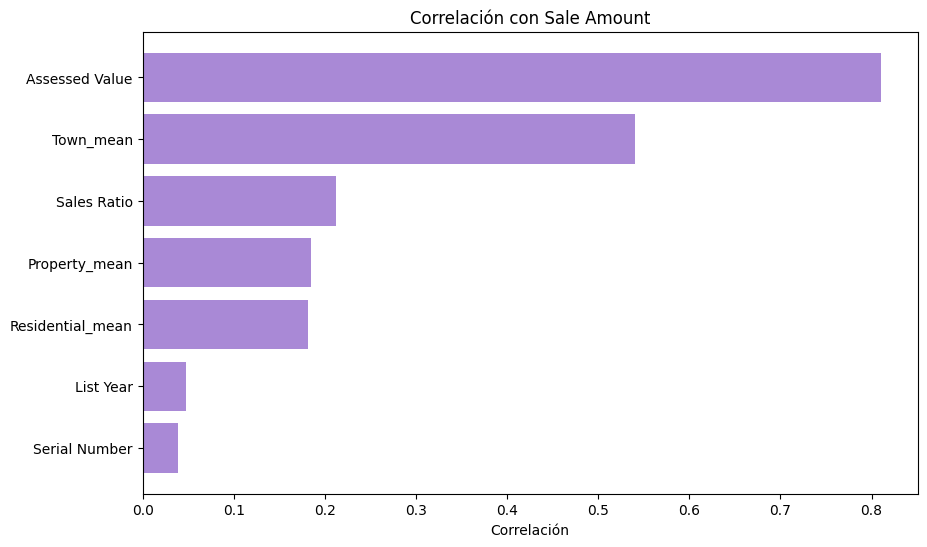

In [40]:
# Grafico las variables y su correlacion con la variable target
plt.figure(figsize=(10, 6))  # Tamaño de la figura
plt.barh(matriz_correlacion_target.index,
         matriz_correlacion_target.values,
         color = '#A989D6')
plt.xlabel('Correlación')
plt.title('Correlación con Sale Amount')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la característica más relevante en la parte superior
plt.show()

### Analisando la variable "Assessed Value": Análisis Univariado


Text(0.5, 1.0, 'Distribución de Assessed Value')

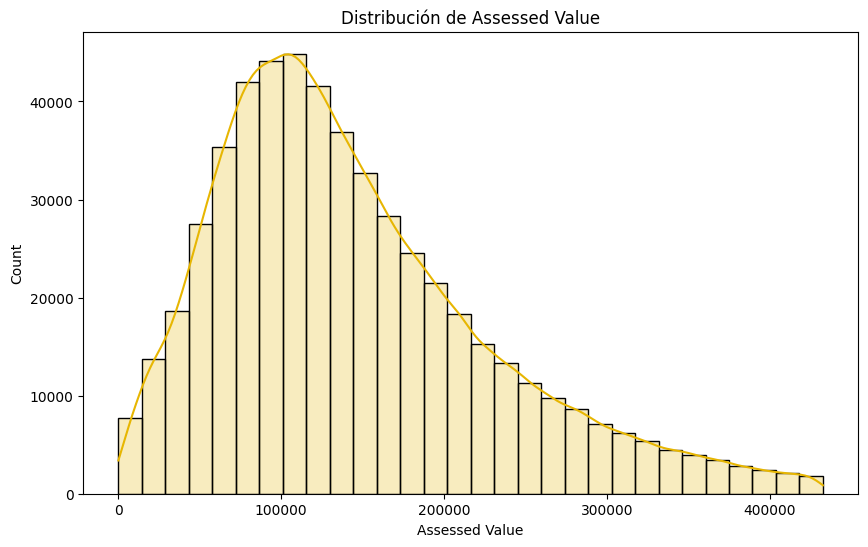

In [41]:
# Cantidad de ventas por precio de tasación
plt.figure(figsize=(10, 6))  # Tamaño de la figura
# Histograma
sns.histplot(data = df,
             x = 'Assessed Value',
             bins = 30,
             alpha = 0.25,
             kde = True,
             color = '#E7B602')
plt.title('Distribución de Assessed Value')

---
Podemos observar que la mayor cantidad de registros se encuentran entre los valores de tasacion que van desde los 50.000 a 200.000 dolares.

---

### Analisando la variable "Assessed Value": Análisis Bivariado
Objetivo final: Predecir precio de venta de una casa.

Lo próximo que haremos es ver cómo es la relación de esta variable con nuestro target.

Variable dependiente: "Sale Amount"

Variable independiente: "Assessed Value"


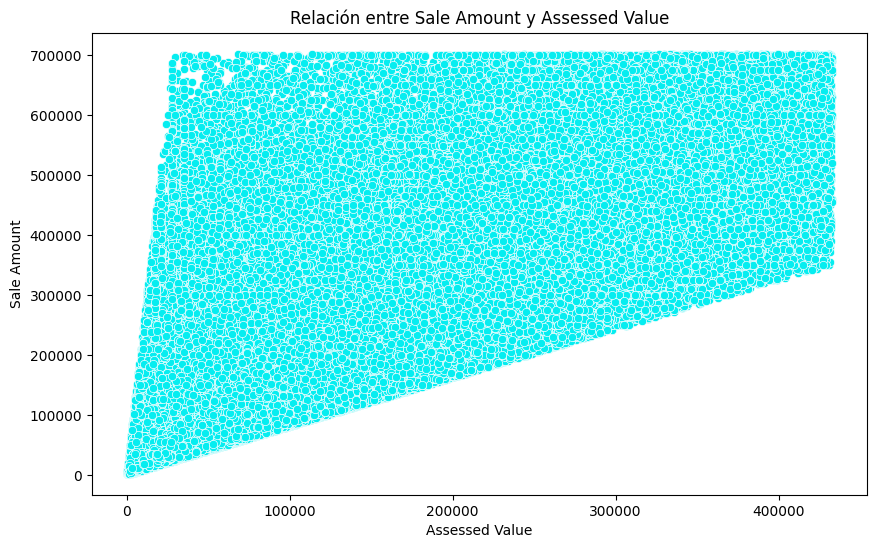

In [42]:
# Visualmente Variable independiente "Assessed Value" y su relacion con Sale Amount

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df,
                x = 'Assessed Value',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Assessed Value')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y Assessed Value')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

---
Se detecta una relacion positiva entre las variables analizadas ya que, a medida que Assessed Value aumenta, Sale Amount tambien aumenta.


---


### Analizamos la variable "Town_mean":  Análisis Univariado
Objetivo final: Predecir precio de venta de una casa.

Variable independiente: "Town_mean"

Text(0.5, 1.0, 'Distribución de Town_mean')

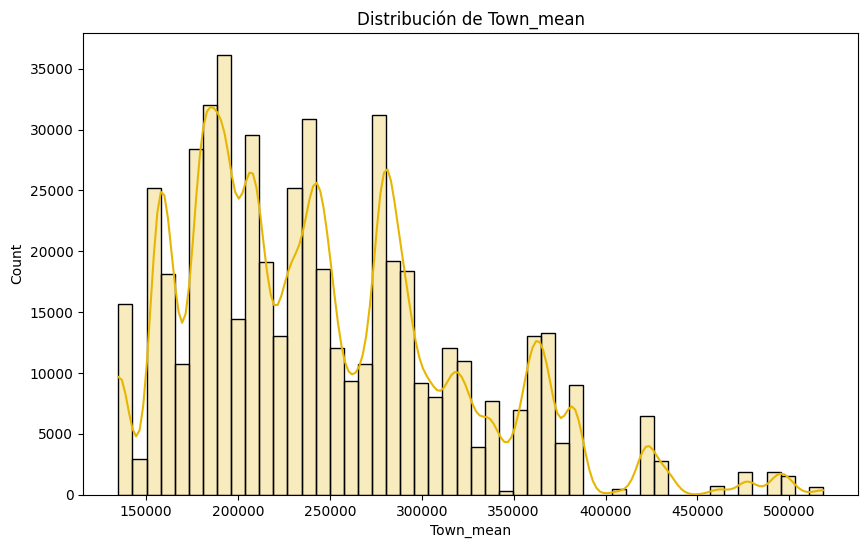

In [43]:
# Cantidad de ventas por ciudad
plt.figure(figsize=(10, 6))  # Tamaño de la figura
# Histograma
sns.histplot(data = df,
             x = 'Town_mean',
             bins = 50,
             alpha = 0.25,
             kde = True,
             color = '#E7B602')
plt.title('Distribución de Town_mean')

---
Podemos observar que a medida que la media calculada para nuestra columna TOWN aumenta, la cantidad de registros disminuye.
Lo que nos da un indicio de que la mayor cantidad de registros se encuentra en los valores bajos de ventas, quedando pocas ventas en valores altos.

---

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Danbury'),
  Text(1, 0, 'Hartford'),
  Text(2, 0, 'Norwalk'),
  Text(3, 0, 'Milford'),
  Text(4, 0, 'Meriden'),
  Text(5, 0, 'New Haven'),
  Text(6, 0, 'Stamford'),
  Text(7, 0, 'Waterbury'),
  Text(8, 0, 'West Hartford'),
  Text(9, 0, 'Bridgeport')])

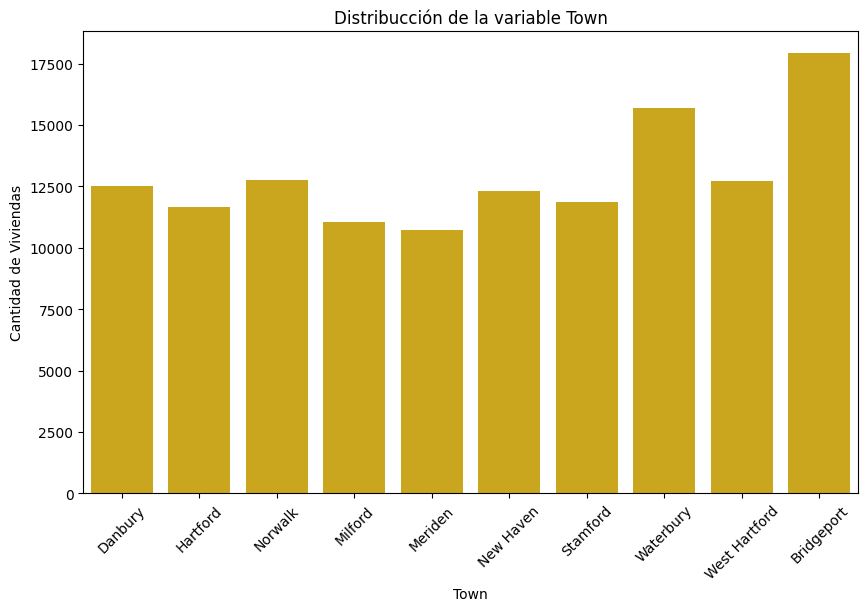

In [44]:
# Cantidad de ventas por las principales 10 Ciudades.
# Para este analisis utilizaremos la variable original Town.
top_cities1 = df['Town'].value_counts().nlargest(10) # Primero, obtén los 10 principales valores de 'Town' en términos de la cantidad de casos
df_top_cities1 = df[df['Town'].isin(top_cities1.index)] # Luego, crea un subconjunto del DataFrame original con solo las filas que corresponden a las 10 principales ciudades

plt.figure(figsize=(10, 6))  # Tamaño de la figura
sns.countplot(data = df_top_cities1,
              x = 'Town',
             color = '#E7B602')
plt.title('Distribucción de la variable Town')
plt.ylabel('Cantidad de Viviendas')
plt.xticks(rotation=45)

---
Observamos que la mayor cantidad de ventas se encuentras registradas en la ciudad de Bridgeport, con aproximadamente 17.500 ventas.

---

### Analizamos la variable "Town_mean":  Análisis Bivariado
Objetivo final: Predecir precio de venta de una casa.

Variable dependiente: "Sale Amount"

Variable independiente: "Town_mean"


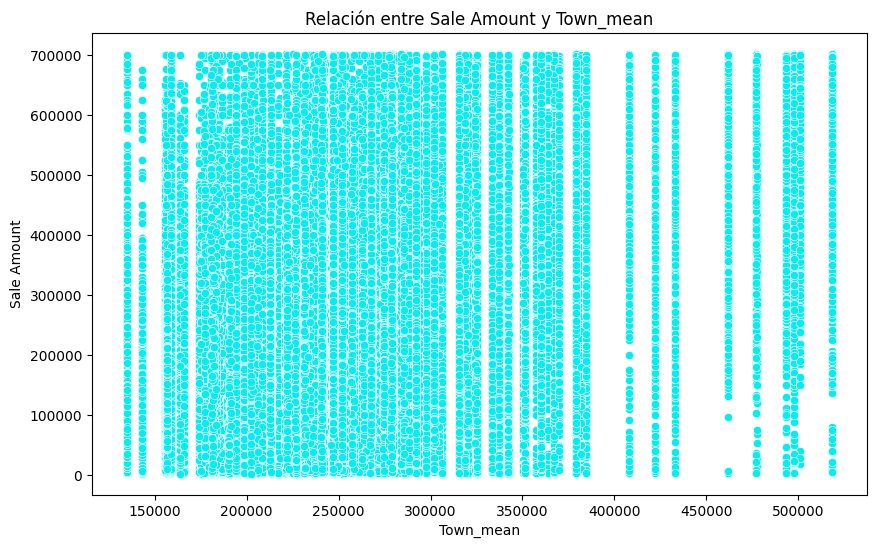

In [45]:
# Visualmente Variable independiente "Town_mean" y su relacion con Sale Amount

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df,
                x = 'Town_mean',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Town_mean')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y Town_mean')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

---
No se encuentra una relacion marcada entre Town_mean y Sale Amount. Solo podemos detectar que la mayor cantidad de registros se encuentra entre los valores de 180.000 y 350.000 de la variable Town_mean

Aplicaremos un top 10 en este caso tambien, para poder visualizar una relacion entre Sale Amount y las principales 10 ciudades.

---



(array([100000., 150000., 200000., 250000., 300000., 350000., 400000.]),
 [Text(100000.0, 0, '100000'),
  Text(150000.0, 0, '150000'),
  Text(200000.0, 0, '200000'),
  Text(250000.0, 0, '250000'),
  Text(300000.0, 0, '300000'),
  Text(350000.0, 0, '350000'),
  Text(400000.0, 0, '400000')])

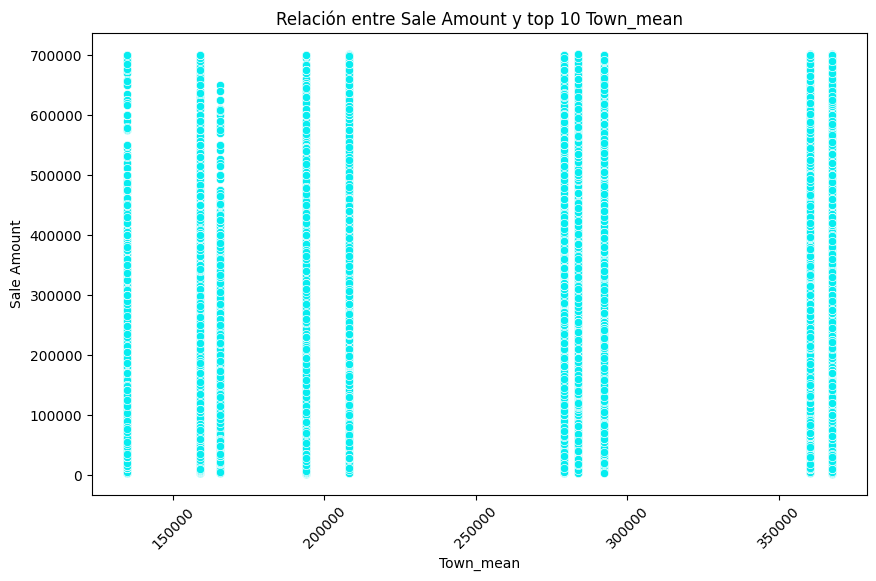

In [46]:
# Cantidad de ventas por las principales 10 Ciudades.
# Para este analisis utilizaremos la variable Town_mean.
top_cities2 = df['Town_mean'].value_counts().nlargest(10) # Primero, obtén los 10 principales valores de 'Town_mean' en términos de la cantidad de casos
df_top_cities2 = df[df['Town_mean'].isin(top_cities2.index)] # Luego, crea un subconjunto del DataFrame original con solo las filas que corresponden a las 10 principales ciudades

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df_top_cities2,
                x = 'Town_mean',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Town_mean')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y top 10 Town_mean')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

---
No se encuentra una relacion marcada entre las principales 10 ciudade (reprecentadas por la columna Town_mean) y Sale Amount.

---

### Analisando la variable "Sales Ratio": Análisis Univariado


Text(0.5, 1.0, 'Distribución de Sales Ratio')

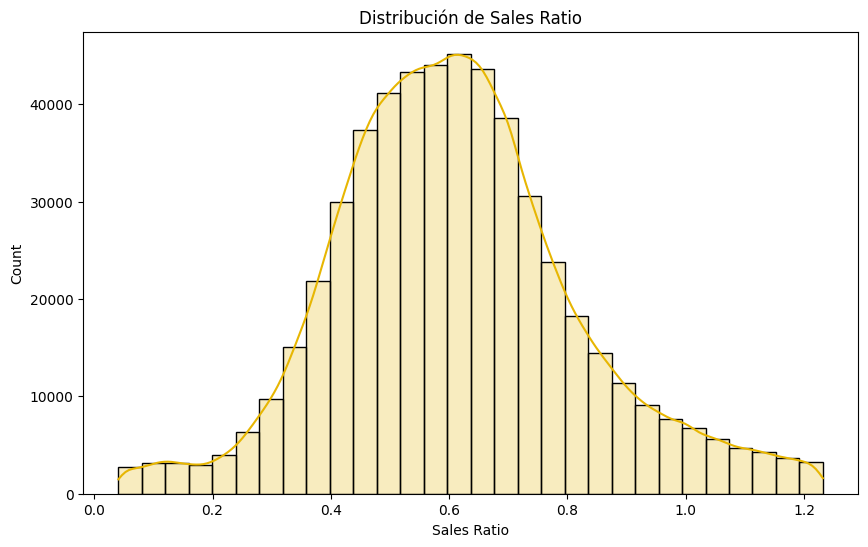

In [47]:
# Cantidad de ventas por Sales Ratio
plt.figure(figsize=(10, 6))  # Tamaño de la figura
# Histograma
sns.histplot(data = df,
             x = 'Sales Ratio',
             bins = 30,
             alpha = 0.25,
             kde = True,
             color = '#E7B602')
plt.title('Distribución de Sales Ratio')

---
Podemos observar que la mayor cantidad de registros se encuentran entre 0.4 Y 0.8 de la variable Sales Ratio. Esto significa que la mayor cantidad de ventas fueron concretadas con precio de venta de entre un 40 % a un 80 % mayor, respecto del valor de tasacion.

En este caso la distribucion de la variable la podemos conciderar como NORMAL.

---

### Analisando la variable "Sales Ratio": Análisis Bivariado
Objetivo final: Predecir precio de venta de una casa.

Lo próximo que haremos es ver cómo es la relación de esta variable con nuestro target.

Variable dependiente: "Sale Amount"

Variable independiente: "Sales Ratio"


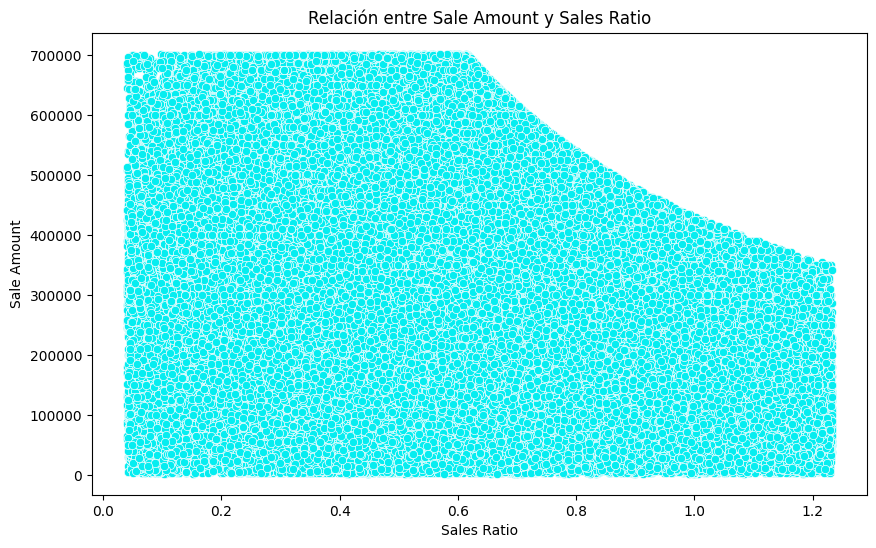

In [48]:
# Visualmente Variable independiente "Sales Ratio" y su relacion con Sale Amount

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df,
                x = 'Sales Ratio',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Sales Ratio')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y Sales Ratio')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

---
Se detecta una relacion negativa entre las variables analizadas, debido a que a medida que aumenta la variable Sales Ratio, disminuye la variable Sale Amount.

Observamos que las propiedades que se vendieron a un precio de hasta 700.000 dolares aproximadamente, pueden tener un ratio de hasta 0.6 aproximadamente.
A partir de este punto el ratio continua aumentando, pero el precio de venta comienza a disminuir hasta llegar a un precio de venta de 350.000 dolares aproximadamente.

En conclución las ventas con mayor ratio, son aquellas que se ubican entre los 2.000 y 350.000 dolares.

---


### Analizamos la variable "Property_mean":  Análisis Univariado
Objetivo final: Predecir precio de venta de una casa.

Variable independiente: "Property_mean"

Text(0.5, 1.0, 'Distribución de Property_mean')

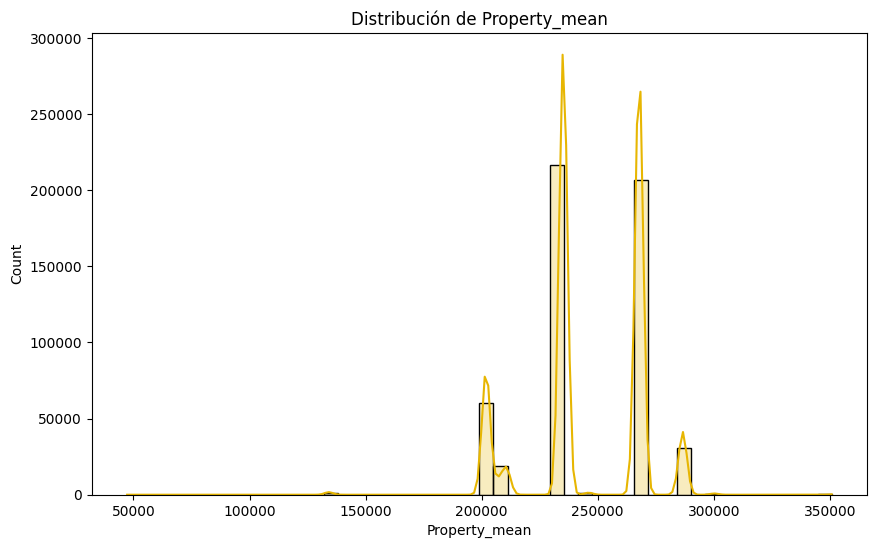

In [49]:
# Cantidad de ventas por tipo de propiedad
plt.figure(figsize=(10, 6))  # Tamaño de la figura
# Histograma
sns.histplot(data = df,
             x = 'Property_mean',
             bins = 50,
             alpha = 0.25,
             kde = True,
             color = '#E7B602')
plt.title('Distribución de Property_mean')

---
Podemos observar que la mayor cantidad de registros se encuentra en los tipos de propiedades cuya media se encuentra entre 200.000 y los 300.000 dolares.

Esto nos da un indicio que la mayor cantidad de ventas se encuentra 5 tipos de propiedades.

Pasaremos a analizar cuales son dichos tipos de propiedades.

---

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Residential'),
  Text(1, 0, 'No data'),
  Text(2, 0, 'Condo'),
  Text(3, 0, 'Two Family'),
  Text(4, 0, 'Single Family')])

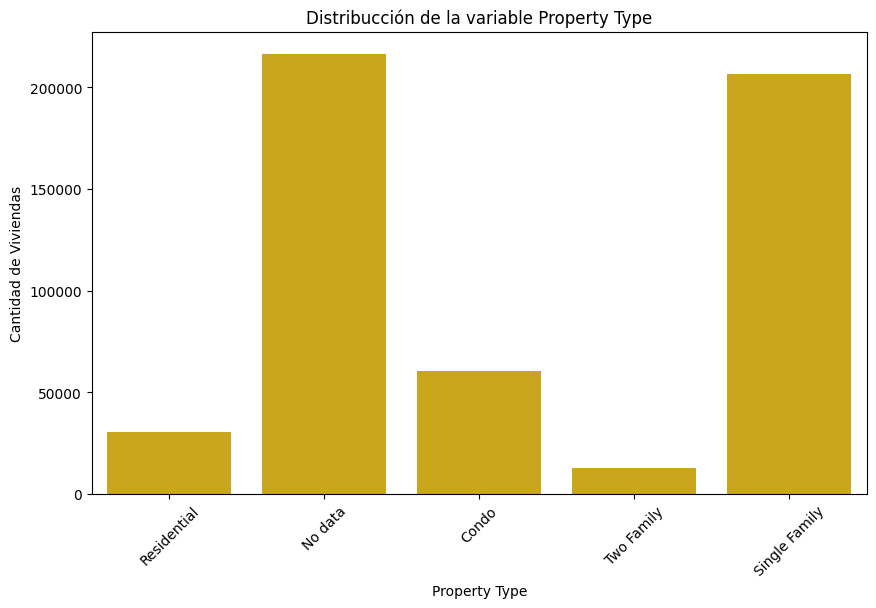

In [50]:
# Cantidad de ventas por los principales 5 tipos de propiedad
# Para este analisis utilizaremos la variable original Property Type.
top_property = df['Property Type'].value_counts().nlargest(5) # Primero, obtenemos los 5 principales valores de 'Property Type' en términos de la cantidad de casos
df_top_property = df[df['Property Type'].isin(top_property.index)] # Luego, creamos un subconjunto del DataFrame original con solo las filas que corresponden a las 5 principales tipos de propiedades

plt.figure(figsize=(10, 6))  # Tamaño de la figura
sns.countplot(data = df_top_property,
              x = 'Property Type',
             color = '#E7B602')
plt.title('Distribucción de la variable Property Type')
plt.ylabel('Cantidad de Viviendas')
plt.xticks(rotation=45)

---
Observamos que la mayor cantidad de ventas se encuentran sin datos(mas de 200.000) en el tipo de propiedad, en segundo lugar se encuentran los tipo Single Family(entre 180.000 y 200.000 ventas) y tercer lugar los tipo Condo (mas de 50.000 y menos de 100.000 ventas aproximadamente).

---


### Analizamos la variable "Property_mean":  Análisis Bivariado
Objetivo final: Predecir precio de venta de una casa.

Variable dependiente: "Sale Amount"

Variable independiente: "Property_mean"


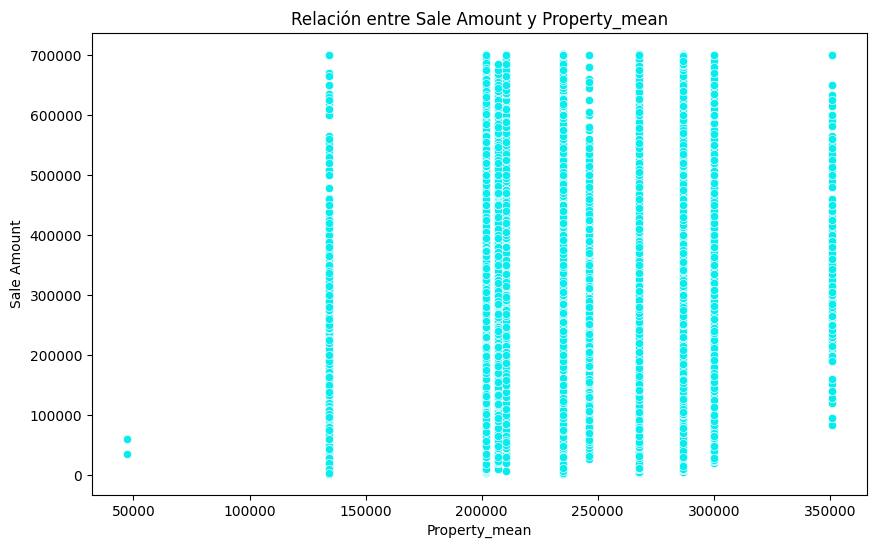

In [51]:
# Visualmente Variable independiente "Property_mean" y su relacion con Sale Amount

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df,
                x = 'Property_mean',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Property_mean')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y Property_mean')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')

---
No se encuentra una relacion marcada entre Property_mean y Sale Amount.

Aplicaremos un top 5 en este caso tambien, para poder visualizar una relacion entre Sale Amount y las principales 5 tipos de propiedades.

---



(array([180000., 200000., 220000., 240000., 260000., 280000., 300000.]),
 [Text(180000.0, 0, '180000'),
  Text(200000.0, 0, '200000'),
  Text(220000.0, 0, '220000'),
  Text(240000.0, 0, '240000'),
  Text(260000.0, 0, '260000'),
  Text(280000.0, 0, '280000'),
  Text(300000.0, 0, '300000')])

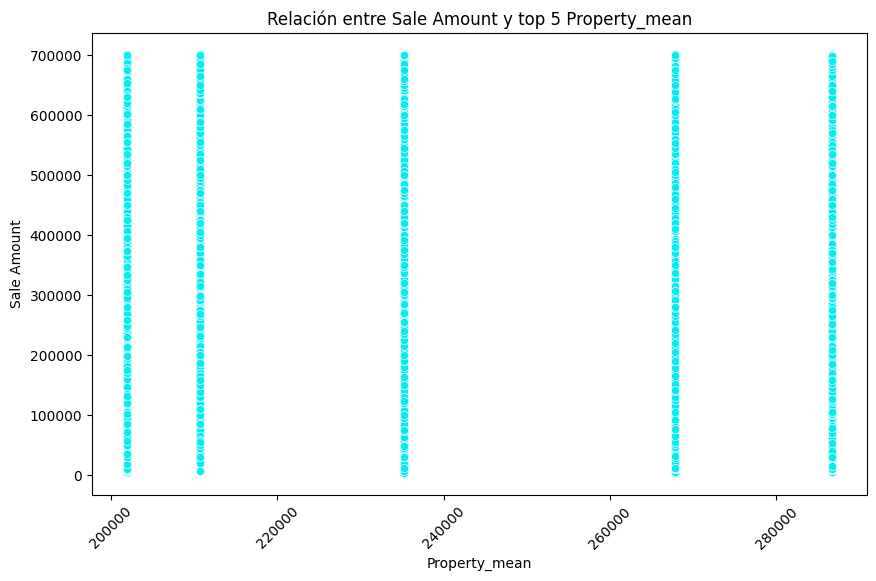

In [52]:
# Cantidad de ventas por las principales 5 tipos de propiedad.
# Para este analisis utilizaremos la variable Property_mean .
top_property1 = df['Property_mean'].value_counts().nlargest(5) # Primero, obtén los 5 principales valores de 'Property_mean ' en términos de la cantidad de casos
df_top_property1 = df[df['Property_mean'].isin(top_property1.index)] # Luego, crea un subconjunto del DataFrame original con solo las filas que corresponden a las 5 principales tipos de propiedad

plt.figure(figsize=(10, 6))
sns.scatterplot(data = df_top_property1,
                x = 'Property_mean',
                y = 'Sale Amount',
               color = '#06EDF0')
plt.xlabel('Property_mean')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y top 5 Property_mean')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

---
No se encuentra una relacion marcada entre los principales 5 tipos de propiedad(reprecentadas por la columna Property_mean) y Sale Amount.

---

### Analizamos la variable "Residential_mean":  Análisis Univariado
Objetivo final: Predecir precio de venta de una casa.

Variable independiente: "Residential_mean"

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Condo'),
  Text(1, 0, 'Single Family'),
  Text(2, 0, 'Two Family'),
  Text(3, 0, 'No data'),
  Text(4, 0, 'Three Family'),
  Text(5, 0, 'Four Family')])

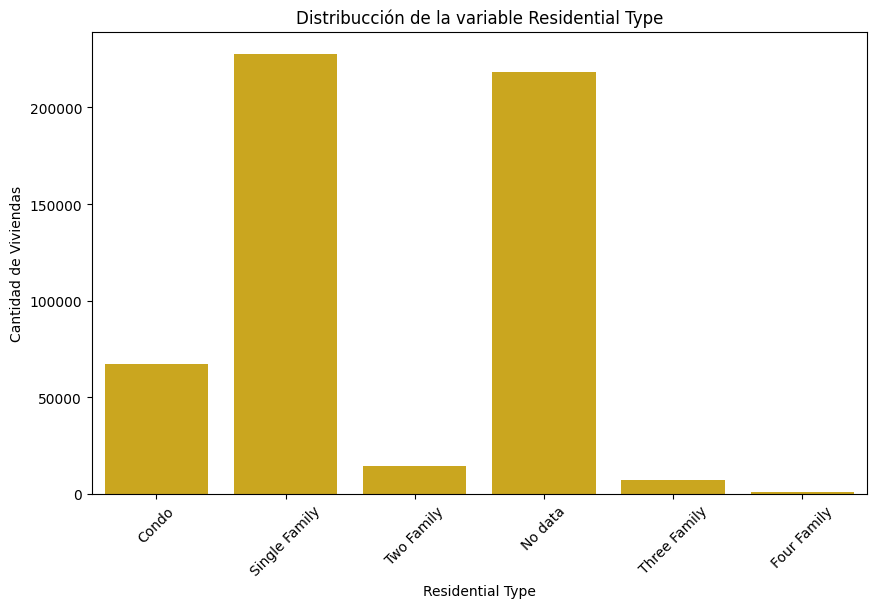

In [53]:
# Cantidad de ventas por tipo de residencia
plt.figure(figsize=(10, 6))
sns.countplot(data = df,
              x = 'Residential Type',
             color = '#E7B602')
plt.title('Distribucción de la variable Residential Type')
plt.ylabel('Cantidad de Viviendas')
plt.xticks(rotation=45)

---

Podemos observar que la mayor cantidad de registros se encuentra en 3 tipos de residencia principalmente.


Observamos que la mayor cantidad de ventas se pertenecen a los tipos de residencia Single Family (mas de 200.000), en segundo lugar los registros sin datos (entre 200.000 y 220.000) y tercer lugar los tipo Condo (alrededor de 70.000).

---

### Analizamos la variable "Residential_mean":  Análisis Bivariado
Objetivo final: Predecir precio de venta de una casa.

Variable dependiente: "Sale Amount"

Variable independiente: "Residential_mean"


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '203432.03289969542'),
  Text(1, 0, '213964.40867940796'),
  Text(2, 0, '214570.4574607635'),
  Text(3, 0, '234862.23093015805'),
  Text(4, 0, '252259.9316317229'),
  Text(5, 0, '272056.82365624356')])

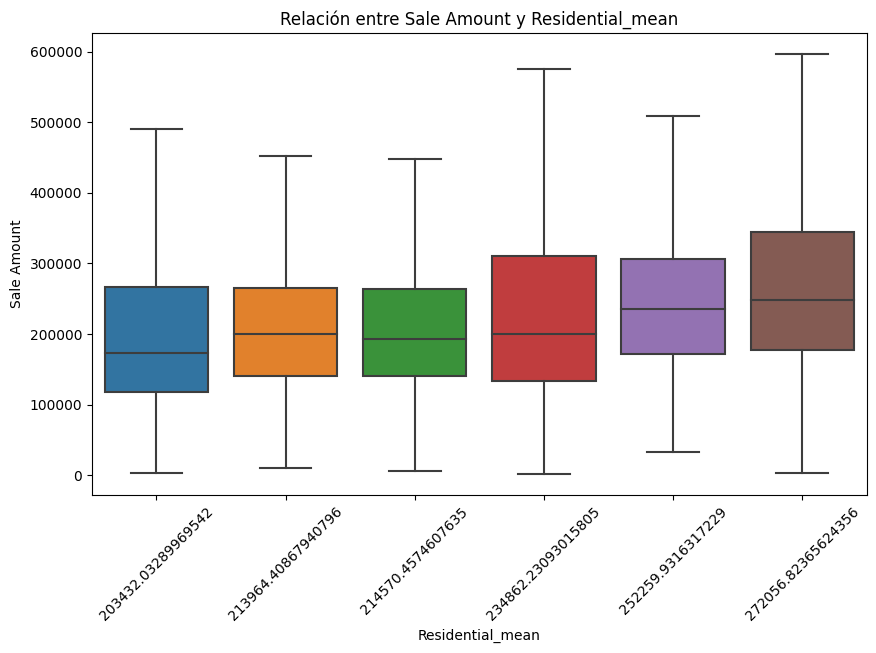

In [54]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data = df,
            x = 'Residential_mean',
            y = 'Sale Amount',
            showfliers = False)
plt.title('Relación entre Sale Amount y Residential_mean')
plt.xticks(rotation=45)

---

Se observa una pequeña relacion positiva entre las variables analizadas, ya que a medida que aumenta la variable Residential_mean, tambien aumenta la variable Sale Amount.

---


##**Modelo de regresión lineal.**


### Integraremos en un modelo de regresión lineal a todas las variable que estuvimos análizando.
La mismas las vamos a agregar una por una.

Objetivo final: Predecir precio de venta de una casa.

Variable dependiente: "Sale Amount"

1) Variable independiente: "Assessed Value"

2) Variable independiente: "Town_mean"

3) Variable independiente: "Property_mean"

4) Variable independiente: "Residential_mean"

5) Variable independiente: "Sales Ratio"


## 1) Variable independiente: "Assessed Value"

In [55]:
# Definimos la variable independiente (X) y la variable dependiente (y)
X = df['Assessed Value']
y = df['Sale Amount']

In [56]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)


In [57]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()


In [58]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())


                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                 1.022e+06
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:03:58   Log-Likelihood:            -6.8066e+06
No. Observations:              535876   AIC:                         1.361e+07
Df Residuals:                  535874   BIC:                         1.361e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.899e+04    214.423    275.

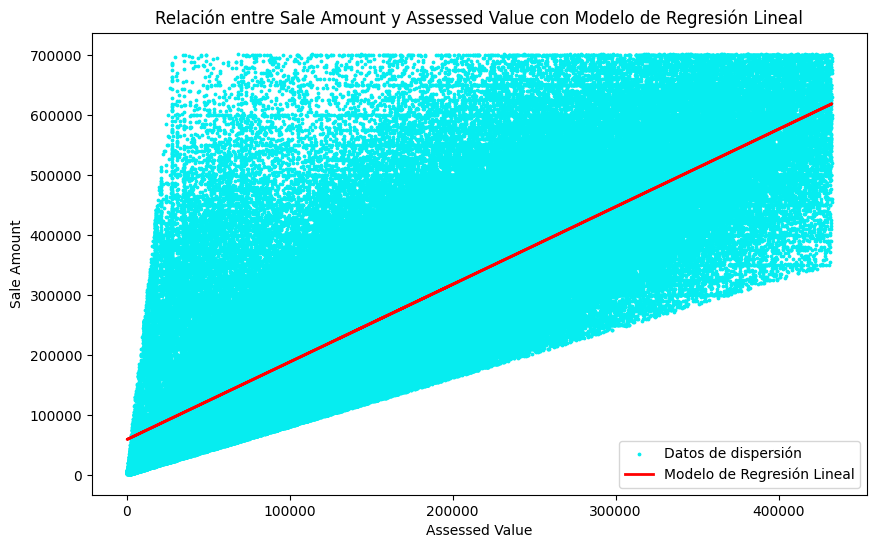

In [59]:
# Visualmente la relacion de mi variable con modelo de regresion lineal
plt.figure(figsize=(10, 6))
plt.scatter(X['Assessed Value'], y, s=3, color='#06EDF0', label='Datos de dispersión')
plt.plot(X['Assessed Value'], modelo_ols.predict(X), color='red', linewidth=2, label='Modelo de Regresión Lineal')
plt.xlabel('Assessed Value')
plt.ylabel('Sale Amount')
plt.title('Relación entre Sale Amount y Assessed Value con Modelo de Regresión Lineal')
plt.legend()
plt.show()

In [60]:
coeficientes = modelo_ols.params
print('Coeficientes:')
print(coeficientes)

Coeficientes:
const            58990.8
Assessed Value       1.3
dtype: float64


In [61]:
intervalo_confianza = modelo_ols.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                     0       1
const          58570.6 59411.1
Assessed Value     1.3     1.3


Intervalo de confianza solo tiene valores positivos, esto confirma la pendiente positiva

In [62]:
pvalores = modelo_ols.pvalues
print('P-Valores:')
print(pvalores.round(10))

P-Valores:
const            0.0
Assessed Value   0.0
dtype: float64


El valor p cero (0.000) para "Assessed Value" indica que esta variable es estadísticamente significativa en la predicción del "Sale Amount" en el modelo de regresión lineal.

In [63]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.656


---
Continuaremos agregando mas variables a nuestro modelo para verificar si podemos mejorar nuestros resultados.


---

## 2) Variable independiente: "Town_mean"

In [64]:
# Definimos la variable independiente (X) y la variable dependiente (y)
X = df[['Assessed Value', 'Town_mean']]
y = df['Sale Amount']

In [65]:
# Visualizamos X
X.head()

,Assessed Value,Town_mean
0,130400.0,333536.8
1,171360.0,324309.9
2,168900.0,272773.3
3,94920.0,184745.5
4,85680.0,184745.5


In [66]:
# Verificamos presencia de nulos en X
X.isna().sum()

Assessed Value    0
Town_mean         0
dtype: int64

In [67]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)

In [68]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()


In [69]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())


                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                 5.561e+05
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:            -6.7916e+06
No. Observations:              535876   AIC:                         1.358e+07
Df Residuals:                  535873   BIC:                         1.358e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5273.9291    369.665     14.

In [70]:
coeficientes = modelo_ols.params
print('Coeficientes:')
print(coeficientes)

Coeficientes:
const            5273.9
Assessed Value      1.2
Town_mean           0.3
dtype: float64


In [71]:
intervalo_confianza = modelo_ols.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                    0      1
const          4549.4 5998.5
Assessed Value    1.2    1.2
Town_mean         0.3    0.3


Intervalo de confianza solo tiene valores positivos, esto confirma la pendiente positiva

In [72]:
pvalores = modelo_ols.pvalues
print('P-Valores:')
print(pvalores.round(10))

P-Valores:
const            0.0
Assessed Value   0.0
Town_mean        0.0
dtype: float64


El valor p cero (0.000) para "Town_mean" indica que esta variable es estadísticamente significativa en la predicción del "Sale Amount" en el modelo de regresión lineal.

In [73]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.675


---

El Coeficiente de determinación (R-cuadrado) aumenta unos puntos, por lo que  lo tendremos en cuenta para este modelo.

---


## 3) Variable independiente: "Property_mean"

In [74]:
# Definimos la variable independiente (X) y la variable dependiente (y)
X = df[['Assessed Value', 'Town_mean', 'Property_mean']]
y = df['Sale Amount']

In [75]:
# Visualizamos X
X.head()

,Assessed Value,Town_mean,Property_mean
0,130400.0,333536.8,286655.2
1,171360.0,324309.9,286655.2
2,168900.0,272773.3,286655.2
3,94920.0,184745.5,286655.2
4,85680.0,184745.5,286655.2


In [76]:
# Verificamos presencia de nulos en X
X.isna().sum()

Assessed Value    0
Town_mean         0
Property_mean     0
dtype: int64

In [77]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)


In [78]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()


In [79]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                 3.714e+05
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:            -6.7912e+06
No. Observations:              535876   AIC:                         1.358e+07
Df Residuals:                  535872   BIC:                         1.358e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3.282e+04   1154.054     28.

In [80]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.675


In [81]:
intervalo_confianza = modelo_ols.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                     0       1
const          30562.1 35086.0
Assessed Value     1.2     1.2
Town_mean          0.3     0.3
Property_mean     -0.1    -0.1


---
El Coeficiente de determinación (R-cuadrado) no varía.

El intervalo de confianza es negativo y muy bajo.

No tendremos en cuenta Property_mean para este modelo.


---


## 4) Variable independiente: "Residential_mean"

In [82]:
# Definimos la variable independiente (X) y la variable dependiente (y)
X = df[['Assessed Value', 'Town_mean', 'Residential_mean']]
y = df['Sale Amount']

In [83]:
# Visualizamos X
X.head()

,Assessed Value,Town_mean,Residential_mean
0,130400.0,333536.8,203432.0
1,171360.0,324309.9,272056.8
2,168900.0,272773.3,272056.8
3,94920.0,184745.5,272056.8
4,85680.0,184745.5,214570.5


In [84]:
# Verificamos presencia de nulos en X
X.isna().sum()

Assessed Value      0
Town_mean           0
Residential_mean    0
dtype: int64

In [85]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)

In [86]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()

In [87]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                 3.748e+05
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:04:10   Log-Likelihood:            -6.7896e+06
No. Observations:              535876   AIC:                         1.358e+07
Df Residuals:                  535872   BIC:                         1.358e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             7.589e+04   1178.411  

In [88]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.677


In [89]:
intervalo_confianza = modelo_ols.conf_int()
print("Intervalo de confianza de los coeficientes:")
print(intervalo_confianza)

Intervalo de confianza de los coeficientes:
                       0       1
const            73582.0 78201.3
Assessed Value       1.2     1.2
Town_mean            0.3     0.3
Residential_mean    -0.3    -0.3


---
El Coeficiente de determinación (R-cuadrado) es practicamente igual.

El intervalo de confianza es negativo. Lo cual nos podria causar ambiguedad en nuestro modelo.

No tendremos en cuenta Residential_mean para este modelo.

---


## 5) Variable independiente: "Sales Ratio"

Esta variable no tiene sentido que la incorporemos al modelo de prediccion por que es resultado de la variable que estamos queriendo predecir.

# Conclusiones:

---

* Intervalo de confianza solo tiene valores positivos, esto confirma la pendiente positiva.

* Los valor p cero (0.000) para indica que estas variables son estadísticamente significativa en la predicción del "Sale Amount" en el modelo de regresión lineal.

* El Coeficiente de determinación (R-cuadrado) es 0.675, lo que significa que aproximadamente el 67.5% de la variabilidad en "Sale Amount" es explicada por las variables independientes incluidas en tu modelo

---


# Metodo one-hot encoding

Vamos a utilizar el metodo one-hot encoding para incorporar algunas variables categoricas a nuestro modelo de regresion lineal.

Variables categoricas:




In [90]:
features_categoricas = df.select_dtypes(include=['object'])
features_categoricas.columns

Index(['Date Recorded', 'Town', 'Address', 'Property Type', 'Residential Type',
       'Non Use Code', 'Assessor Remarks', 'OPM remarks', 'Location'],
      dtype='object')

In [91]:
# Cuántos valores distintos tiene cada categoría?
valores_distintos = features_categoricas.nunique()
print(valores_distintos.sort_values(ascending=False))

Address             431346
Location             79360
Assessor Remarks     30047
Date Recorded         5981
OPM remarks           2555
Town                   170
Non Use Code            99
Property Type           12
Residential Type         6
dtype: int64


De todas estas variables solo nos quedan disponibles las siguientes:

* Para estas 4 variables utilizaremos otro metodo:
  * Address   -     Valores distintos:     431346
  * Location    -   Valores distintos:       79360
  * Assessor Remarks - Valores distintos:    30047
  * OPM remarks    -   Valores distintos:     2555


* La variable "Date Recorded" no la utilizaremos para crear una nueva variable por tiene una relacion directa con la variable a predecir.

* Por mas que vemos que la variable Non Use Code tiene muchos registros distintos y que se nos generarian 98 nuevas columnas, la utilizaremos y veremos resultados:

  * Non Use Code   -    Valores distintos:      99



In [92]:
# Agrupamos para analisar informacion
Agrupacion_Non_Use_Code = df.groupby('Non Use Code')
Agrupacion_Non_Use_Code

In [93]:
conteo_por_grupo = Agrupacion_Non_Use_Code.size()
conteo_ordenado = conteo_por_grupo.sort_values(ascending=False)
print(conteo_ordenado)

Non Use Code
No data                    420681
25 - Other                  24079
14 - Foreclosure            20517
07 - Change in Property     16250
7.0                          7082
                            ...  
32.0                            1
88                              1
38.0                            1
55.0                            1
73.0                            1
Length: 99, dtype: int64


In [94]:
#Creando variables dummy "Non Use Code"
df = pd.get_dummies(df, columns=['Non Use Code'])
df

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,...,Non Use Code_4,Non Use Code_5,Non Use Code_6,Non Use Code_7,Non Use Code_74,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family
0,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7,Residential,Condo,...,0,0,0,0,0,0,0,0,1,0
1,20139,2020,12/16/2020,Bethel,16 DEEPWOOD DRIVE,171360.0,335000.0,0.5,Residential,Single Family,...,0,0,0,0,0,0,0,0,1,0
2,200086,2020,08/10/2021,Bethlehem,39 WOODLAND RD,168900.0,352000.0,0.5,Residential,Single Family,...,0,0,0,0,0,0,0,0,1,0
3,200032,2020,10/08/2020,Bristol,9 LESLIE COURT,94920.0,155000.0,0.6,Residential,Single Family,...,0,0,0,0,0,0,0,0,1,0
4,200527,2020,03/01/2021,Bristol,25 WARD ST,85680.0,183000.0,0.5,Residential,Two Family,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535871,190365,2019,02/10/2020,West Hartford,191 HUNTER DRIVE,315420.0,380000.0,0.8,Single Family,Single Family,...,0,0,0,0,0,0,0,0,1,0
535872,190159,2019,12/13/2019,Wallingford,530-A5 CENTER ST,128700.0,175000.0,0.7,Condo,Condo,...,0,0,0,0,0,0,0,0,1,0
535873,191401,2019,07/30/2020,Waterbury,355 PIERPONT RD,81070.0,142000.0,0.6,Single Family,Single Family,...,0,0,0,0,0,0,0,0,1,0
535874,190284,2019,11/27/2019,Waterbury,126 PERKINS AVE,68280.0,76000.0,0.9,Single Family,Single Family,...,0,0,0,0,0,0,0,0,0,0


En la columna 'Non Use Code' puede ser util el metodo que estamos utilizando ya que dicho codigo puede repetirse en varios registros. En este caso se generar 100 columnas adicionales aproximadamente.
Esto no es bueno para nuestro modelo, por lo que si queremos utilizar este metodo, deberiamos primero agrupar los registros de la variable 'Non Use Code'. Como podemos observar algunos codigos se utiilizan en 1 o pocos registros de ventas, agrupandolos podriamos disminuir la cantidad de registros distintos en esa columna. Esto nos daria como resultado la generacion de menos columnas adicionales.

No creo conveniente utilizar este metodo para los demás campos categoricos debido a que cada venta tiene un registro particular para cada columna. Esto me generaria miles de columnas adicionales (1 columna por registro).

Por lo que las variables de direccion, ubicacion, observaciones y comentarios las incorporaremos al modelo solo teniendo en cuenta si tienen registro o no en el dataset.

## Creando nuevos campos

Crearemos algunos campos nuevos para luego incluirlos en nuestro modelo de regresion.

1) Vamos a generar 4 nuevas columnas que haran referencia a:

* Address: direccion (si el registro tiene direccion = 1, si el registro no tiene direccion = 0)
* Location: ubicación (si el registro tiene ubicacion = 1, si el registro no tiene ubicacion = 0)
* Assessor Remarks: Observaciones del asesor (si el registro tiene observaciones = 1, si el registro no tiene observaciones = 0)
* OPM remarks: Comentario de la operación (si el registro tiene comentarios = 1, si el registro no tiene comentarios = 0)

Al tratar los nulos en el Dataset los registros nulos los reemplazamos como 'No data'. Tomaremos ese dato para reemplazar los 'No data' = 0 y el resto de los registros = 1.


In [95]:
# 1) Vamos a generar 4 nuevas columnas.
df['Address_SI_NO'] = df['Address'].apply(lambda x: 0 if x == 'No data' else 1)
df['Location_SI_NO'] = df['Location'].apply(lambda x: 0 if x == 'No data' else 1)
df['Assessor Remarks_SI_NO'] = df['Assessor Remarks'].apply(lambda x: 0 if x == 'No data' else 1)
df['OPM remarks_SI_NO'] = df['OPM remarks'].apply(lambda x: 0 if x == 'No data' else 1)
df.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,...,Non Use Code_74,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO
0,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7,Residential,Condo,...,0,0,0,0,1,0,1,0,0,0
1,20139,2020,12/16/2020,Bethel,16 DEEPWOOD DRIVE,171360.0,335000.0,0.5,Residential,Single Family,...,0,0,0,0,1,0,1,0,0,0
2,200086,2020,08/10/2021,Bethlehem,39 WOODLAND RD,168900.0,352000.0,0.5,Residential,Single Family,...,0,0,0,0,1,0,1,1,0,0
3,200032,2020,10/08/2020,Bristol,9 LESLIE COURT,94920.0,155000.0,0.6,Residential,Single Family,...,0,0,0,0,1,0,1,0,0,0
4,200527,2020,03/01/2021,Bristol,25 WARD ST,85680.0,183000.0,0.5,Residential,Two Family,...,0,0,0,0,1,0,1,0,0,0


## Agregamos a nuestro modelo, las variables Dummy y variables nuevas cradas con contenido binario.

In [96]:
# identificaremos las columnas binarias (variables binarias) en este DF las columnas binareas solo tienen valores 0 o 1.
columnas_binarias = [col for col in df.columns if set(df[col]) == {0, 1}]

In [97]:
# Creamos un nuevo objeto Variables_binarias
Variables_binarias = df[columnas_binarias]

In [98]:
Variables_binarias

,Non Use Code_1.0,Non Use Code_2.0,Non Use Code_3.0,Non Use Code_4.0,Non Use Code_5.0,Non Use Code_6.0,Non Use Code_7.0,Non Use Code_8.0,Non Use Code_9.0,Non Use Code_10.0,...,Non Use Code_74,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
535872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
535873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
535874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [99]:
# Definimos la variable independiente (X) y la variable dependiente (y)
# Definimos las características numéricas
caracteristicas_numericas = ['Assessed Value', 'Town_mean']

# Creamos un listado que contenga todas las características a incluir en X
columnas_a_incluir = caracteristicas_numericas + columnas_binarias

X = df[columnas_a_incluir]
y = df['Sale Amount']

In [100]:
# Visualizamos X
X.head()

,Assessed Value,Town_mean,Non Use Code_1.0,Non Use Code_2.0,Non Use Code_3.0,Non Use Code_4.0,Non Use Code_5.0,Non Use Code_6.0,Non Use Code_7.0,Non Use Code_8.0,...,Non Use Code_74,Non Use Code_8,Non Use Code_88,Non Use Code_9,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO
0,130400.0,333536.8,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,171360.0,324309.9,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,168900.0,272773.3,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,94920.0,184745.5,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,85680.0,184745.5,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [101]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)

In [102]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()

In [103]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                 1.471e+04
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:04:37   Log-Likelihood:            -6.7310e+06
No. Observations:              535876   AIC:                         1.346e+07
Df Residuals:                  535771   BIC:                         1.346e+07
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [104]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.741


## Conclusiones
---
Podemos obtener las siguientes observaciones:

* Nuestro R-cuadrado mejoró de 0.675 a 0.741.
* R-squared (R-cuadrado): El valor de R-cuadrado es 0.741, lo que significa que aproximadamente el 74.1% de la variabilidad en "Sale Amount" es explicada por las variables independientes incluidas en el modelo. Esto nos da un indicio de que el modelo de regresión lineal parece tener un buen ajuste.
* Adj. R-squared (R-cuadrado ajustado): Es similar al R-cuadrado, pero ajusta la métrica según el número de variables independientes en el modelo. Un valor alto indica un buen ajuste.
* Es importante prestar atención a los valores p. Los valores p más pequeños indican que las variables son más estadísticamente significativas en la predicción de la variable dependiente. En este modelo algunas variables parecen tener valores p muy altos, lo que sugiere que podrían no ser estadísticamente significativas.

Continuaremos analizando mas a detalle los resultados para decidir si es conveniente tomar todas estas variables Dummy incorporadas al modelo.

Independiente de lo expuesto anteriormente continuaremos creando mas variables e incorporandolas al modelo de regresión, con el objetivo de mejorar los resultados.

---

# MODELO DE TESTEO Y RESULTADOS

In [105]:
DF_TEST.info

<bound method DataFrame.info of         Serial Number  List Year Date Recorded           Town  \
1               20002       2020    10/02/2020        Ashford   
14             201295       2020    09/09/2021        Bristol   
16             200354       2020    12/29/2020        Bristol   
18             201212       2020    08/23/2021        Bristol   
22             200117       2020    04/12/2021         Canton   
...               ...        ...           ...            ...   
997203         190302       2019    11/29/2019      Waterbury   
997205         190161       2019    03/02/2020      Newington   
997206          19921       2019    11/18/2019     West Haven   
997208         190272       2019    06/24/2020     New London   
997210         190129       2019    04/27/2020  Windsor Locks   

                Address  Assessed Value  Sale Amount  Sales Ratio  \
1       390 TURNPIKE RD        253000.0     430000.0          0.6   
14          609 CAMP ST        144340.0     24990

## 1) Fusionamos Agrupacion_Town (calculado en el df de entrenamiento), con nuetro DF_TEST.
El objetivo es poder convertir la variable categorica 'Town' en variable numerica, utilizando la media calculada en el df de entrenamiento.

Solo haremos la fusion con esta variable ya que es la unica con la que nos quedamos en el analisis final de regresión.


In [106]:
# Fusionsmos (DF_TEST) con (Agrupacion_Town) utilizando la columna "Town" como clave
DF_TEST = DF_TEST.merge(Agrupacion_Town, on='Town', how='left')

In [107]:
DF_TEST

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,Sale Amount Log,TRAIN,Town_mean
0,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.6,Residential,Single Family,No data,No data,No data,No data,13.0,0,184392.8
1,201295,2020,09/09/2021,Bristol,609 CAMP ST,144340.0,249900.0,0.6,Residential,Single Family,No data,No data,No data,No data,12.4,0,184745.5
2,200354,2020,12/29/2020,Bristol,391 TIFFANY LA,173740.0,299000.0,0.6,Residential,Single Family,No data,No data,No data,No data,12.6,0,184745.5
3,201212,2020,08/23/2021,Bristol,8 JENNINGS TERR,88060.0,91000.0,1.0,Residential,Single Family,14 - Foreclosure,FORECLOSURE SALE OUT OF BANK,No data,No data,11.4,0,184745.5
4,200117,2020,04/12/2021,Canton,52 COUNTRY LANE,160850.0,280000.0,0.6,Residential,Single Family,No data,No data,No data,No data,12.5,0,277614.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229869,190302,2019,11/29/2019,Waterbury,122 WOLCOTT ST,77870.0,112000.0,0.7,Three Family,Three Family,No data,No data,No data,No data,11.6,0,134951.1
229870,190161,2019,03/02/2020,Newington,22 ROCKLEDGE DR,306000.0,456000.0,0.7,Single Family,Single Family,No data,No data,No data,No data,13.0,0,205608.8
229871,19921,2019,11/18/2019,West Haven,75 CLOVER ST,125230.0,246000.0,0.5,Single Family,Single Family,No data,No data,No data,POINT (-72.96445 41.25722),12.4,0,181806.6
229872,190272,2019,06/24/2020,New London,4 BISHOP CT,60410.0,53100.0,1.1,Single Family,Single Family,14 - Foreclosure,No data,No data,No data,10.9,0,180920.1


In [108]:
# Verificamos la existencia de nulos en DF_TEST
DF_TEST.isnull().sum()

Serial Number       0
List Year           0
Date Recorded       0
Town                0
Address             0
Assessed Value      0
Sale Amount         0
Sales Ratio         0
Property Type       0
Residential Type    0
Non Use Code        0
Assessor Remarks    0
OPM remarks         0
Location            0
Sale Amount Log     0
TRAIN               0
Town_mean           0
dtype: int64

## Metodo one-hot encoding en DF_TEST

Vamos a utilizar el metodo one-hot encoding para incorporar algunas variables categoricas a nuestro modelo de regresion lineal.

Variables categoricas:

1. Non Use Code: codigo de no uso


In [109]:
#Creando variables dummy "Non Use Code"
DF_TEST = pd.get_dummies(DF_TEST, columns=['Non Use Code'])
DF_TEST

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,...,Non Use Code_3,Non Use Code_30 - Auction,Non Use Code_32,Non Use Code_4,Non Use Code_5,Non Use Code_6,Non Use Code_7,Non Use Code_8,Non Use Code_No data,Non Use Code_Single Family
0,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.6,Residential,Single Family,...,0,0,0,0,0,0,0,0,1,0
1,201295,2020,09/09/2021,Bristol,609 CAMP ST,144340.0,249900.0,0.6,Residential,Single Family,...,0,0,0,0,0,0,0,0,1,0
2,200354,2020,12/29/2020,Bristol,391 TIFFANY LA,173740.0,299000.0,0.6,Residential,Single Family,...,0,0,0,0,0,0,0,0,1,0
3,201212,2020,08/23/2021,Bristol,8 JENNINGS TERR,88060.0,91000.0,1.0,Residential,Single Family,...,0,0,0,0,0,0,0,0,0,0
4,200117,2020,04/12/2021,Canton,52 COUNTRY LANE,160850.0,280000.0,0.6,Residential,Single Family,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229869,190302,2019,11/29/2019,Waterbury,122 WOLCOTT ST,77870.0,112000.0,0.7,Three Family,Three Family,...,0,0,0,0,0,0,0,0,1,0
229870,190161,2019,03/02/2020,Newington,22 ROCKLEDGE DR,306000.0,456000.0,0.7,Single Family,Single Family,...,0,0,0,0,0,0,0,0,1,0
229871,19921,2019,11/18/2019,West Haven,75 CLOVER ST,125230.0,246000.0,0.5,Single Family,Single Family,...,0,0,0,0,0,0,0,0,1,0
229872,190272,2019,06/24/2020,New London,4 BISHOP CT,60410.0,53100.0,1.1,Single Family,Single Family,...,0,0,0,0,0,0,0,0,0,0


Crearemos algunos campos nuevos para luego incluirlos en nuestro modelo de regresion.

1) Vamos a generar 4 nuevas columnas que haran referencia a:

* Address: direccion (si el registro tiene direccion = 1, si el registro no tiene direccion = 0)
* Location: ubicación (si el registro tiene ubicacion = 1, si el registro no tiene ubicacion = 0)
* Assessor Remarks: Observaciones del asesor (si el registro tiene observaciones = 1, si el registro no tiene observaciones = 0)
* OPM remarks: Comentario de la operación (si el registro tiene comentarios = 1, si el registro no tiene comentarios = 0)

Al tratar los nulos en el Dataset los registros nulos los reemplazamos como 'No data'. Tomaremos ese dato para reemplazar los 'No data' = 0 y el resto de los registros = 1

In [110]:
# 1) Vamos a generar 4 nuevas columnas.
DF_TEST['Address_SI_NO'] = DF_TEST['Address'].apply(lambda x: 0 if x == 'No data' else 1)
DF_TEST['Location_SI_NO'] = DF_TEST['Location'].apply(lambda x: 0 if x == 'No data' else 1)
DF_TEST['Assessor Remarks_SI_NO'] = DF_TEST['Assessor Remarks'].apply(lambda x: 0 if x == 'No data' else 1)
DF_TEST['OPM remarks_SI_NO'] = DF_TEST['OPM remarks'].apply(lambda x: 0 if x == 'No data' else 1)
DF_TEST.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,...,Non Use Code_5,Non Use Code_6,Non Use Code_7,Non Use Code_8,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO
0,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.6,Residential,Single Family,...,0,0,0,0,1,0,1,0,0,0
1,201295,2020,09/09/2021,Bristol,609 CAMP ST,144340.0,249900.0,0.6,Residential,Single Family,...,0,0,0,0,1,0,1,0,0,0
2,200354,2020,12/29/2020,Bristol,391 TIFFANY LA,173740.0,299000.0,0.6,Residential,Single Family,...,0,0,0,0,1,0,1,0,0,0
3,201212,2020,08/23/2021,Bristol,8 JENNINGS TERR,88060.0,91000.0,1.0,Residential,Single Family,...,0,0,0,0,0,0,1,0,1,0
4,200117,2020,04/12/2021,Canton,52 COUNTRY LANE,160850.0,280000.0,0.6,Residential,Single Family,...,0,0,0,0,1,0,1,0,0,0


## Analizamos nuestro modelo de regresion lineal en DF_TEST incorporando todas las variables nuevas.

In [111]:
# identificaremos las columnas binarias (variables binarias) en este DF_TEST las columnas binareas solo tienen valores 0 o 1.
columnas_binarias_TEST = [col for col in DF_TEST.columns if set(DF_TEST[col]) == {0, 1}]

In [112]:
# Creamos un nuevo objeto Variables_binarias_TEST
Variables_binarias_TEST = DF_TEST[columnas_binarias_TEST]

In [113]:
Variables_binarias_TEST

,Non Use Code_1.0,Non Use Code_2.0,Non Use Code_3.0,Non Use Code_4.0,Non Use Code_5.0,Non Use Code_6.0,Non Use Code_7.0,Non Use Code_8.0,Non Use Code_9.0,Non Use Code_10.0,...,Non Use Code_5,Non Use Code_6,Non Use Code_7,Non Use Code_8,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
229870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
229871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
229872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [114]:
# Definimos la variable independiente (X) y la variable dependiente (y)
# Definimos las características numéricas
caracteristicas_numericas_TEST = ['Assessed Value', 'Town_mean']

# Creamos un listado que contenga todas las características a incluir en X
columnas_a_incluir_TEST = caracteristicas_numericas_TEST + columnas_binarias_TEST

X = DF_TEST[columnas_a_incluir_TEST]
y = DF_TEST['Sale Amount']

In [115]:
# Visualizamos X
X.head()

,Assessed Value,Town_mean,Non Use Code_1.0,Non Use Code_2.0,Non Use Code_3.0,Non Use Code_4.0,Non Use Code_5.0,Non Use Code_6.0,Non Use Code_7.0,Non Use Code_8.0,...,Non Use Code_5,Non Use Code_6,Non Use Code_7,Non Use Code_8,Non Use Code_No data,Non Use Code_Single Family,Address_SI_NO,Location_SI_NO,Assessor Remarks_SI_NO,OPM remarks_SI_NO
0,253000.0,184392.8,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,144340.0,184745.5,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,173740.0,184745.5,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,88060.0,184745.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,160850.0,277614.2,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [116]:
# Agregamos una constante a la variable independiente para incluir el intercepto
X = sm.add_constant(X)

In [117]:
# Ajustamos el modelo de regresión lineal usando OLS
modelo_ols = sm.OLS(y, X).fit()

In [118]:
# Analizamos los resultados del modelo
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            Sale Amount   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     6714.
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:04:46   Log-Likelihood:            -2.8871e+06
No. Observations:              229874   AIC:                         5.774e+06
Df Residuals:                  229776   BIC:                         5.775e+06
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [119]:
r_cuadrado = modelo_ols.rsquared
print("Coeficiente de determinación (R-cuadrado):", r_cuadrado.round(3))

Coeficiente de determinación (R-cuadrado): 0.739




# Conclusiones DF_TEST
---
Al contar con resultados muy similares tanto en DF_TRAIN como en DF_TEST podriamos decir que no estamos en presencia de sobreajuste o subajuste

---